In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import glob
import os
import sklearn.model_selection


## Metadata Preprocessing

We begin by loading and cleaning the metadata. This includes selecting relevant columns, encoding categorical variables (`sex` and `diagnosis_1`), and handling missing values by imputing with the mean. We also create a new `filename` column to match image files with metadata.

In [2]:

metadata = pd.read_csv('metadata.csv')
metadata = metadata[['isic_id','age_approx','clin_size_long_diam_mm','sex','diagnosis_1']]
# encode columns
metadata['sex'] = metadata['sex'].map({'male': 0, 'female': 1})
metadata['diagnosis_1'] = metadata['diagnosis_1'].map({'Benign': 0, 'Malignant': 1})

# missing values
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].mean())
metadata['clin_size_long_diam_mm'] = metadata['clin_size_long_diam_mm'].fillna(metadata['clin_size_long_diam_mm'].mean())
metadata = metadata.dropna()

# Create filename field
metadata['filename'] = metadata['isic_id'].astype(str) + '.jpg'


/var/folders/0b/33n254b510726mq07nrfcfbw0000gn/T/ipykernel_4880/695260491.py:1: DtypeWarning: Columns (6,9,10,11,13,14,15,16,17,18,19,22,23,25,26,27,28,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv')


In [3]:
metadata.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,filename
0,ISIC_9536278,45.0,3.988203,1.0,1.0,ISIC_9536278.jpg
1,ISIC_7650956,65.0,3.988203,1.0,1.0,ISIC_7650956.jpg
2,ISIC_5730927,85.0,3.988203,0.0,1.0,ISIC_5730927.jpg
3,ISIC_4305055,85.0,3.988203,1.0,1.0,ISIC_4305055.jpg
4,ISIC_5681611,85.0,3.988203,1.0,1.0,ISIC_5681611.jpg


## Filter Valid Image Paths

We filter the metadata to keep only those entries that have valid corresponding image files, as listed in `good_image_paths.txt`.

In [4]:
'''
good_image_paths = []

for path in valid_image_paths:
    try:
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        good_image_paths.append(path)
    except:
        print(f"Skipping invalid image: {path}")

with open('good_image_paths.txt', 'w') as f:
    for path in good_image_paths:
        f.write(f"{path}\n")
'''

'\ngood_image_paths = []\n\nfor path in valid_image_paths:\n    try:\n        img_raw = tf.io.read_file(path)\n        img = tf.image.decode_jpeg(img_raw, channels=3)\n        good_image_paths.append(path)\n    except:\n        print(f"Skipping invalid image: {path}")\n\nwith open(\'good_image_paths.txt\', \'w\') as f:\n    for path in good_image_paths:\n        f.write(f"{path}\n")\n'

In [5]:
with open('good_image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

filenames = [os.path.basename(p) for p in image_paths]
metadata = metadata[metadata['filename'].isin(filenames)].reset_index(drop=True)


## Create Lookup Dictionaries for Metadata

We create dictionaries that map filenames to metadata features (sex, age, size) and class labels for training.

In [6]:
# Create lookup dictionaries
label_lookup = dict(zip(metadata['filename'], metadata['diagnosis_1']))
# Lists for matched data
valid_image_paths = []
labels = []


for path, fname in zip(image_paths, filenames):
    if fname in label_lookup:
        valid_image_paths.append(path)
        labels.append(label_lookup[fname])
    



## Train/Validation/Test Split

We split the dataset into training+validation (90%) and test (10%) sets. This ensures we have a hold-out set for final evaluation.

In [7]:
trainval_paths, test_paths, trainval_labels, test_labels = sklearn.model_selection.train_test_split(
    valid_image_paths, labels,
    test_size=0.1, random_state=42, shuffle=True
)



In [8]:
len(trainval_paths)

436973

## Balancing Classes

To ensure balanced classes, we sample 10,000 images per class from the training+validation data. We then split these into 8,000 for training and 2,000 for validation and copy them into separate folders for later use with `image_dataset_from_directory`.

In [9]:
from collections import defaultdict
import numpy as np
import shutil
import os

# Group filenames by class
label_to_paths = defaultdict(list)
for path, label in zip(trainval_paths, trainval_labels):
    label_to_paths[label].append(path)

# For each class, sample 5000, then split into 4000 train / 1000 val
train_paths, val_paths, train_labels, val_labels = [], [], [], []

for label in [0, 1]:
    paths = label_to_paths[label]
    np.random.seed(42)
    sampled_paths = np.random.choice(paths, 5000, replace=False)
    train_p = sampled_paths[:4000]
    val_p = sampled_paths[4000:]

    train_paths.extend(train_p)
    val_paths.extend(val_p)
    train_labels.extend([label] * 4000)
    val_labels.extend([label] * 1000)

# Create new folders for train/val
for folder in ['images_train_balanced', 'images_val_balanced']:
    os.makedirs(folder, exist_ok=True)

# Copy files into balanced folders
for path in train_paths:
    shutil.copy(path, f'images_train_balanced/{os.path.basename(path)}')

for path in val_paths:
    shutil.copy(path, f'images_val_balanced/{os.path.basename(path)}')


In [10]:

import os
import shutil
os.makedirs('./images_test', exist_ok=True)

for path in test_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_test/{filename}')


## Create TensorFlow Datasets

We use `image_dataset_from_directory` to create TensorFlow datasets for training, validation, and testing. All images are resized to 128×128 pixels and batched for efficient training.

In [11]:
train_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_train_balanced',
    labels=train_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

val_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_val_balanced',
    labels=val_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [12]:
# Test filenames and labels
test_path_to_label = {os.path.basename(p): l for p, l in zip(test_paths, test_labels)}
test_filenames = [os.path.basename(p) for p in test_paths]
test_labels_sorted = [test_path_to_label[fname] for fname in test_filenames]

test_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_test',
    labels=test_labels_sorted,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=False
)


Found 48553 files belonging to 2 classes.


## Model Building and Training

We use a pre-trained MobileNetV2 model as the feature extractor. Initially, we freeze the base model and train only the custom classification head. Then we unfreeze and fine-tune the entire model using a lower learning rate. Early stopping is used to prevent overfitting.

In [15]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom classification head
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train top layers first
history = model.fit(train_image_ds,
                    validation_data=val_image_ds,
                    epochs=20,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# Unfreeze and fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the whole model
history_finetune = model.fit(train_image_ds,
                             validation_data=val_image_ds,
                             epochs=50,
                             callbacks=[EarlyStopping(patience=8, restore_best_weights=True)])


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 178ms/step - accuracy: 0.7203 - loss: 0.5662 - val_accuracy: 0.8035 - val_loss: 0.4586
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.8190 - loss: 0.4173 - val_accuracy: 0.8235 - val_loss: 0.4187
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step - accuracy: 0.8245 - loss: 0.4025 - val_accuracy: 0.8275 - val_loss: 0.4136
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.8336 - loss: 0.3887 - val_accuracy: 0.8305 - val_loss: 0.4039
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.8412 - loss: 0.3802 - val_accuracy: 0.8280 - val_loss: 0.4108
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step - accuracy: 0.8384 - loss: 0.3811 - val_accuracy: 0.8220 - val_loss: 0.4149
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step - accuracy: 0.8413 - loss: 0.3745 - val_accuracy: 0.8285 - val_loss: 0.4032
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - accuracy: 0.8430 - loss: 0

## Model Evaluation on Test Set

We evaluate the model on the hold-out test set and display the classification report and confusion matrix. This helps assess performance on previously unseen data.

In [16]:
test_loss, test_accuracy = model.evaluate(test_image_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

759/759 ━━━━━━━━━━━━━━━━━━━━ 97s 127ms/step - accuracy: 0.3771 - loss: 1.9154
Test accuracy: 0.2013


In [17]:
y_pred_probs = model.predict(test_image_ds)
y_pred = np.round(y_pred_probs).astype(int)

759/759 ━━━━━━━━━━━━━━━━━━━━ 95s 125ms/step


In [18]:
y_true = np.array(test_labels_sorted)

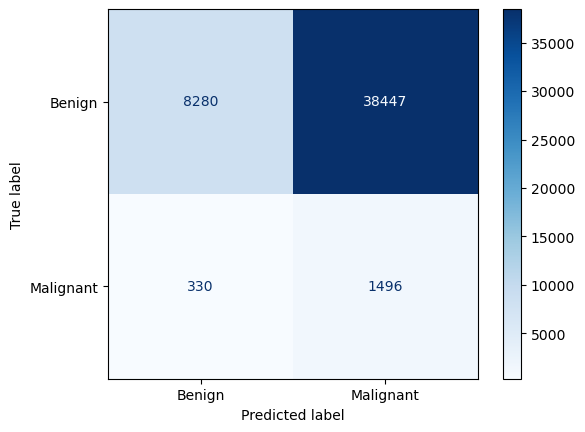

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues',values_format='d')


In [20]:
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.96      0.18      0.30     46727
   Malignant       0.04      0.82      0.07      1826

    accuracy                           0.20     48553
   macro avg       0.50      0.50      0.19     48553
weighted avg       0.93      0.20      0.29     48553



In [21]:
from sklearn.metrics import roc_auc_score


auc = roc_auc_score(y_true, y_pred_probs)
print(f"AUC: {auc:.4f}")


AUC: 0.4935


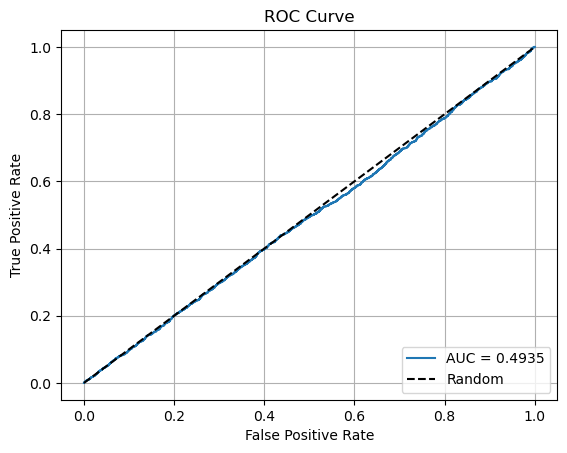

In [22]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Get FPR (false positive rate), TPR (true positive rate), and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Confusion Matrix on Validation Set

We compute predictions on the validation set and visualize the confusion matrix to further assess model performance on validation data.

2025-05-14 09:44:31.523136: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


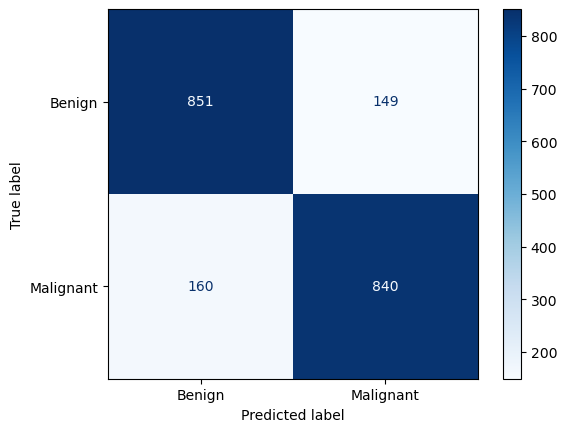

In [23]:
import matplotlib.pyplot as plt
y_true = []
y_pred = []

# Loop through the shuffled dataset in the same order used for prediction
for images, labels in val_image_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.round(preds).astype(int).flatten())  # or np.argmax if softmax
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(val_image_ds)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.8457 - loss: 0.4670


## Save Trained Model

We save the trained model to disk for future inference or fine-tuning.

In [25]:
model.save('model_5000_basic.keras')